In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
validation_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
train_dataset = CIFAR10(root="./data", train=True, transform=train_transform, download=True)
validation_dataset = CIFAR10(root="./data", train=False, transform=validation_transform, download=True)
print(train_dataset)
print("length of train data", len(train_dataset), "length of validation data", len(validation_dataset), "nr of classes", len(train_dataset.classes))

cifar_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
cifar_validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
length of train data 50000 length of validation data 10000 nr of classes 10


In [3]:
from custommodel import CustomModel

cnn_model = CustomModel(32, len(train_dataset.classes))

In [6]:
from trainer import Trainer
ModelTrainer = Trainer(cnn_model, cifar_train_loader, cifar_validation_loader, 10, 0.001)
ModelTrainer.train()

Epoch [1/10], Step [100/1563], Loss: 2.1426
Epoch [1/10], Step [200/1563], Loss: 1.9223
Epoch [1/10], Step [300/1563], Loss: 1.7796
Epoch [1/10], Step [400/1563], Loss: 1.6943
Epoch [1/10], Step [500/1563], Loss: 1.6279
Epoch [1/10], Step [600/1563], Loss: 1.6276
Epoch [1/10], Step [700/1563], Loss: 1.5591
Epoch [1/10], Step [800/1563], Loss: 1.5394
Epoch [1/10], Step [900/1563], Loss: 1.5227
Epoch [1/10], Step [1000/1563], Loss: 1.5130
Epoch [1/10], Step [1100/1563], Loss: 1.4893
Epoch [1/10], Step [1200/1563], Loss: 1.4724
Epoch [1/10], Step [1300/1563], Loss: 1.4413
Epoch [1/10], Step [1400/1563], Loss: 1.4307
Epoch [1/10], Step [1500/1563], Loss: 1.4422
Epoch [1/10], Accuracy on test set: 49.64%
Epoch [2/10], Step [100/1563], Loss: 1.3840
Epoch [2/10], Step [200/1563], Loss: 1.3976
Epoch [2/10], Step [300/1563], Loss: 1.3334
Epoch [2/10], Step [400/1563], Loss: 1.3640
Epoch [2/10], Step [500/1563], Loss: 1.3506
Epoch [2/10], Step [600/1563], Loss: 1.3200
Epoch [2/10], Step [700/156

In [81]:
from torchvision import datasets
from pytorch_ood.utils import ToUnknown
import random
from torch.utils.data import Subset

def set_to_0(_):
    return 0

def set_to_1(_):    
    return 1

# OOD dataset (e.g. SVHN)
ood_dataset = datasets.SVHN(root="data", split="test", transform=validation_transform, download=True, target_transform=ToUnknown())
id_dataset = CIFAR10(root="./data", train=False, transform=validation_transform, download=True)

desired_size = 5000  # for example, keep only 5k samples

# 3. Randomly pick indices for your subset
all_indices = list(range(len(ood_dataset)))
random.shuffle(all_indices)
subset_indices = all_indices[:desired_size]

# 4. Wrap the original dataset with Subset
svhn_subset = Subset(ood_dataset, subset_indices)
print(len(svhn_subset))

loader = DataLoader(svhn_subset + id_dataset, batch_size=128, shuffle = True)

for images, labels in loader:
    print(len(labels))
    print(labels)  # Transformed labels (e.g., some are 1000)
    break


Using downloaded and verified file: data/test_32x32.mat
Files already downloaded and verified
5000
128
tensor([-1, -1,  1,  1,  2,  3, -1,  4,  2,  9, -1, -1,  9,  4,  7,  7,  1,  6,
         9, -1, -1, -1,  8,  8,  2, -1,  4, -1, -1, -1,  2, -1,  5,  0,  3,  0,
        -1, -1,  7,  3, -1,  2,  0, -1, -1, -1,  2, -1, -1, -1,  5,  9,  5,  6,
        -1,  4, -1,  9,  3,  2,  3,  5,  4,  4,  8, -1,  7,  0,  7,  2,  6, -1,
         8,  9, -1, -1, -1, -1, -1, -1, -1,  9,  5, -1,  4,  3,  8, -1, -1, -1,
        -1, -1,  0, -1,  6, -1,  7,  7,  4, -1,  7, -1,  8,  4, -1, -1,  5, -1,
        -1,  5,  0,  8,  5, -1, -1,  8, -1,  4,  7,  0, -1, -1, -1,  3,  0,  6,
        -1, -1])


In [ ]:
import torch
from pytorch_ood.utils import OODMetrics
from pytorch_ood.detector import OpenMax, MultiMahalanobis

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Wrap your trained model with OpenMax
detector = OpenMax(cnn_model.to(device))
cnn_model.eval()

# 2. Create OOD metrics collector
metrics = OODMetrics()

# 3. Fit OpenMax on in-distribution (ID) data
detector.fit(cifar_train_loader)  # Make sure this loader has ID samples

# 4. Evaluate both ID and OOD
with torch.no_grad():
    # ---- OOD pass (label=True for each sample) ----
    for inputs, id in loader:
        inputs = inputs.to(device)
        metrics.update(detector(inputs), id)

# 5. Now compute the metrics (AUROC, etc.)
results = metrics.compute()
print("OpenMax results", results)




{'AUROC': 0.5808442234992981, 'AUTC': 0.5141134262084961, 'AUPR-IN': 0.5124869346618652, 'AUPR-OUT': 0.7144832015037537, 'FPR95TPR': 0.7138000130653381}


In [87]:
from pytorch_ood.detector import OpenMax, MultiMahalanobis
from pytorch_ood.model import WideResNet

model = WideResNet(num_classes=10, pretrained="cifar10-pt").to(device).eval()

layer1 = model.conv1
layer2 = model.block1
layer3 = model.block2
layer4 = model.block3
detector = MultiMahalanobis([layer1, layer2, layer3, layer4])

detector.fit(cifar_train_loader, device=device)

KeyboardInterrupt: 

: 

In [79]:
print("Testing...")
metrics = OODMetrics()

for x, y in loader:
    metrics.update(detector(x.to(device)), y)

print(metrics.compute())

Testing...
{'AUROC': 0.3223710358142853, 'AUTC': 0.514441192150116, 'AUPR-IN': 0.5470985174179077, 'AUPR-OUT': 0.24841156601905823, 'FPR95TPR': 0.9934999942779541}


15000


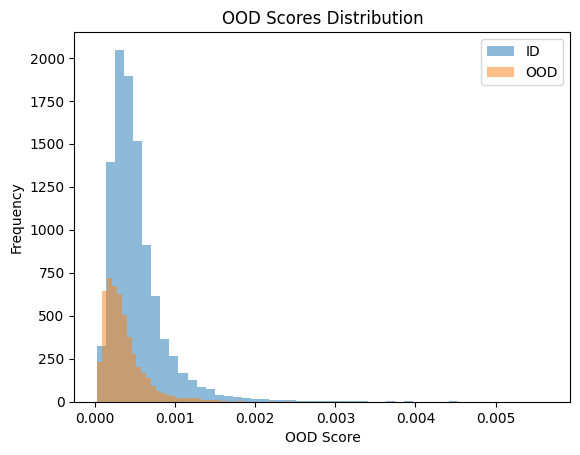

In [86]:
import matplotlib.pyplot as plt

id_scores = []
ood_scores = []

z=0
with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        scores = detector(x)
        for score, label in zip(scores, y):
            z+=1
            if label == -1:
                ood_scores.append(score.item())
            else:
                id_scores.append(score.item())
print(z)
plt.hist(id_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')
plt.title("OOD Scores Distribution")
plt.xlabel("OOD Score")
plt.ylabel("Frequency")
plt.show()


In [62]:
import requests

# URL of the plane image
url = "https://th.bing.com/th/id/R.21621d8860f8aa6040a48c551a930de2?rik=3uoSLAbD6Voriw&riu=http%3a%2f%2fjamsdesignsinc.com%2fwp-content%2fuploads%2f2018%2f06%2fAirplane_01-square-1024x1024.jpg&ehk=n5hvZiqC3bgBZZ3z9tNUuH%2fBdsLAQFf%2bb2atiLN4Vx0%3d&risl=&pid=ImgRaw&r=0"

# Download the image
response = requests.get(url)
if response.status_code == 200:
    with open("plane.jpg", "wb") as f:
        f.write(response.content)
    print("Image downloaded: plane.jpg")
else:
    print("Failed to download image")

from PIL import Image
from torchvision import transforms

# Load the downloaded image
img = Image.open("plane.jpg")

# Define CIFAR-10 preprocessing: resize, convert to tensor, and normalize
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 pixels
    transforms.ToTensor(),       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (CIFAR-10 stats)
])

# Preprocess the image
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
print("Preprocessed image tensor:", input_tensor.shape)

# Load your trained model
cnn_model.eval()  # Ensure the model is in evaluation mode

# Pass the image through the model
with torch.no_grad():
    output = cnn_model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

# CIFAR-10 class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print the prediction
print("Predicted class:", class_labels[predicted_class])


Image downloaded: plane.jpg
Preprocessed image tensor: torch.Size([1, 3, 32, 32])
Predicted class: airplane
